#### Chapter 23
### Analyzing Neural Time Series Data
Python code for Chapter 23 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

### Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import firls, filtfilt
from scipy.fftpack import fft, ifft
from mne import create_info, EvokedArray
from mne.channels import make_dig_montage

### Figure 23.2

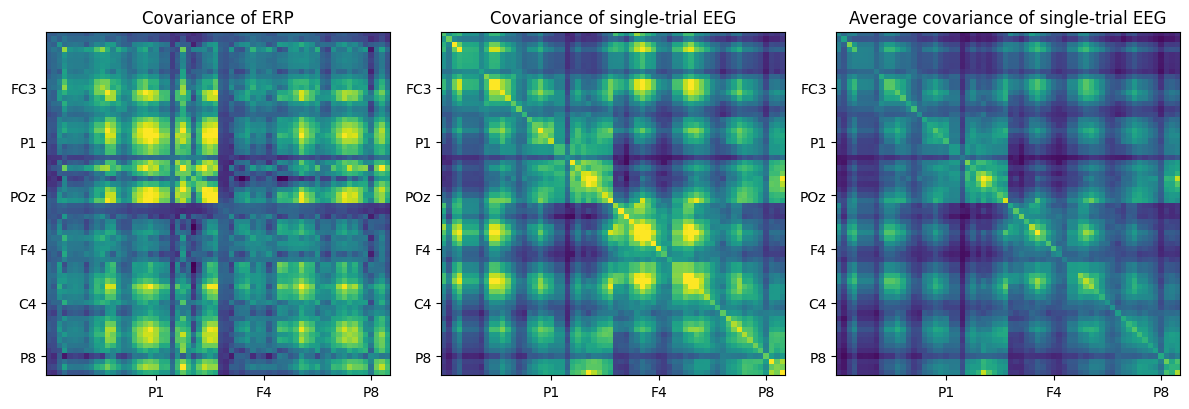

In [ ]:
# Load sample data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Compute ERP
erp = np.mean(EEG['data'], axis=2)

# Subtract mean and compute covariance
erp = erp - np.mean(erp, axis=1, keepdims=True)
covar = np.dot(erp, erp.T) / (EEG['pnts'][0][0] - 1)

plt.figure(figsize=(12, 4))
# Plot covariance of ERP
plt.subplot(131)
plt.imshow(covar, aspect='equal', clim=[-1, 5])
xticks = [20, 40, 60]
yticks = [10, 20, 30, 40, 50, 60]
plt.xticks(xticks)
plt.yticks(yticks)
plt.gca().set_xticklabels([EEG['chanlocs'][0]['labels'][tick-1][0] for tick in xticks])
plt.gca().set_yticklabels([EEG['chanlocs'][0]['labels'][tick-1][0] for tick in yticks])
plt.title('Covariance of ERP')

# One covariance of all timepoints
eeg = np.reshape(EEG['data'], (EEG['nbchan'][0][0], EEG['pnts'][0][0] * EEG['trials'][0][0]), 'F')
eeg = eeg - np.mean(eeg, axis=1, keepdims=True)
covar = np.dot(eeg, eeg.T) / (len(eeg) - 1)

# Plot covariance of single-trial EEG
plt.subplot(132)
plt.imshow(covar, aspect='equal', clim=[20000, 150000])
xticks = [20, 40, 60]
yticks = [10, 20, 30, 40, 50, 60]
plt.xticks(xticks)
plt.yticks(yticks)
plt.gca().set_xticklabels([EEG['chanlocs'][0]['labels'][tick-1][0] for tick in xticks])
plt.gca().set_yticklabels([EEG['chanlocs'][0]['labels'][tick-1][0] for tick in yticks])
plt.title('Covariance of single-trial EEG')

# Average single-trial covariances
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= i

# Plot average covariance of single-trial EEG
plt.subplot(133)
plt.imshow(covar, aspect='equal', clim=[20, 150])
xticks = [20, 40, 60]
yticks = [10, 20, 30, 40, 50, 60]
plt.xticks(xticks)
plt.yticks(yticks)
plt.gca().set_xticklabels([EEG['chanlocs'][0]['labels'][tick-1][0] for tick in xticks])
plt.gca().set_yticklabels([EEG['chanlocs'][0]['labels'][tick-1][0] for tick in yticks])
plt.title('Average covariance of single-trial EEG')

plt.tight_layout()
plt.show()

### Figure 23.3

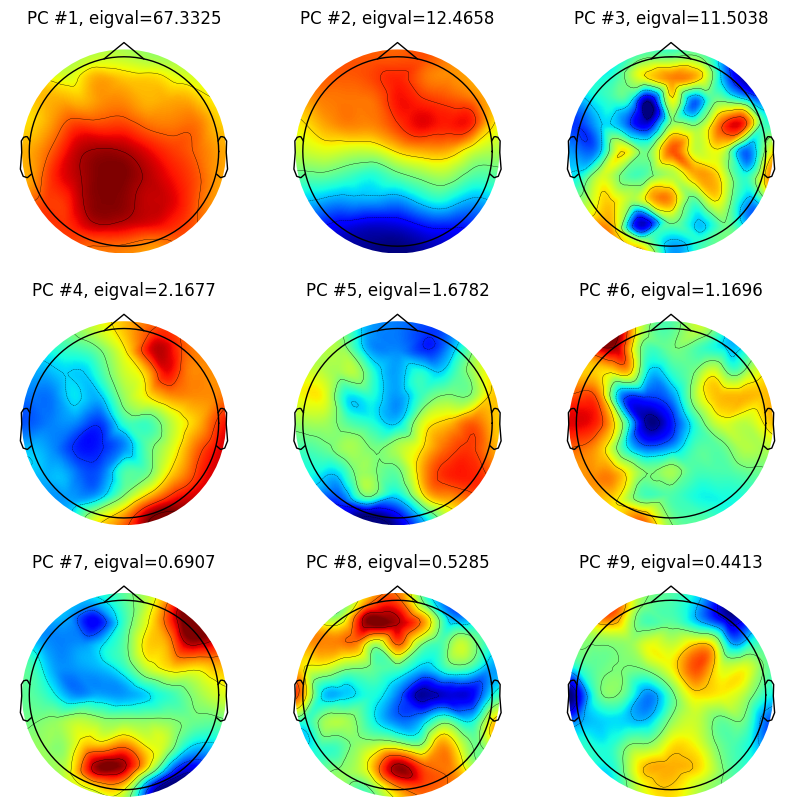

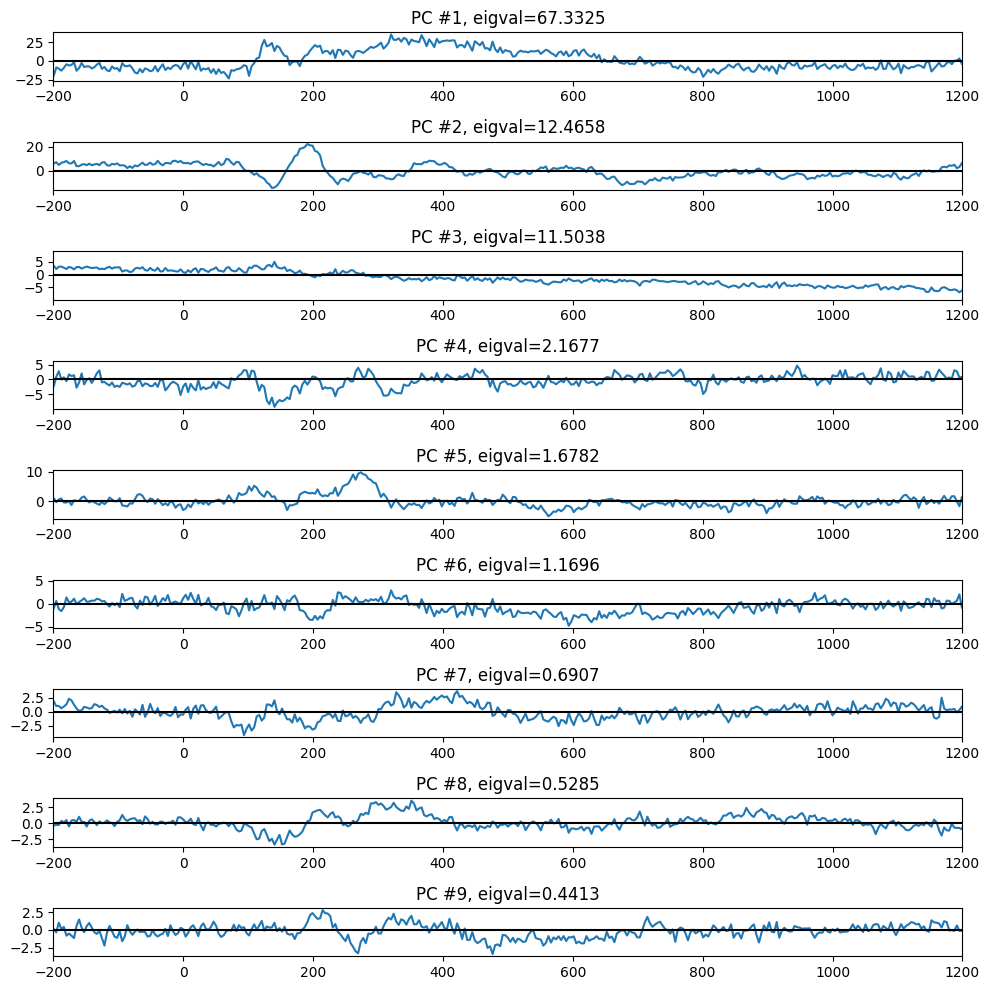

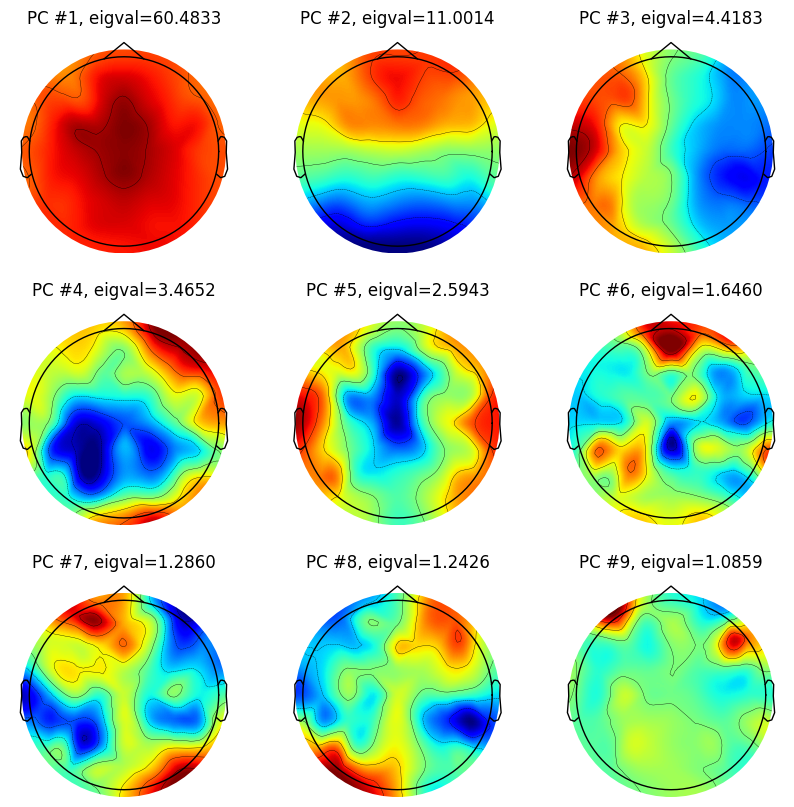

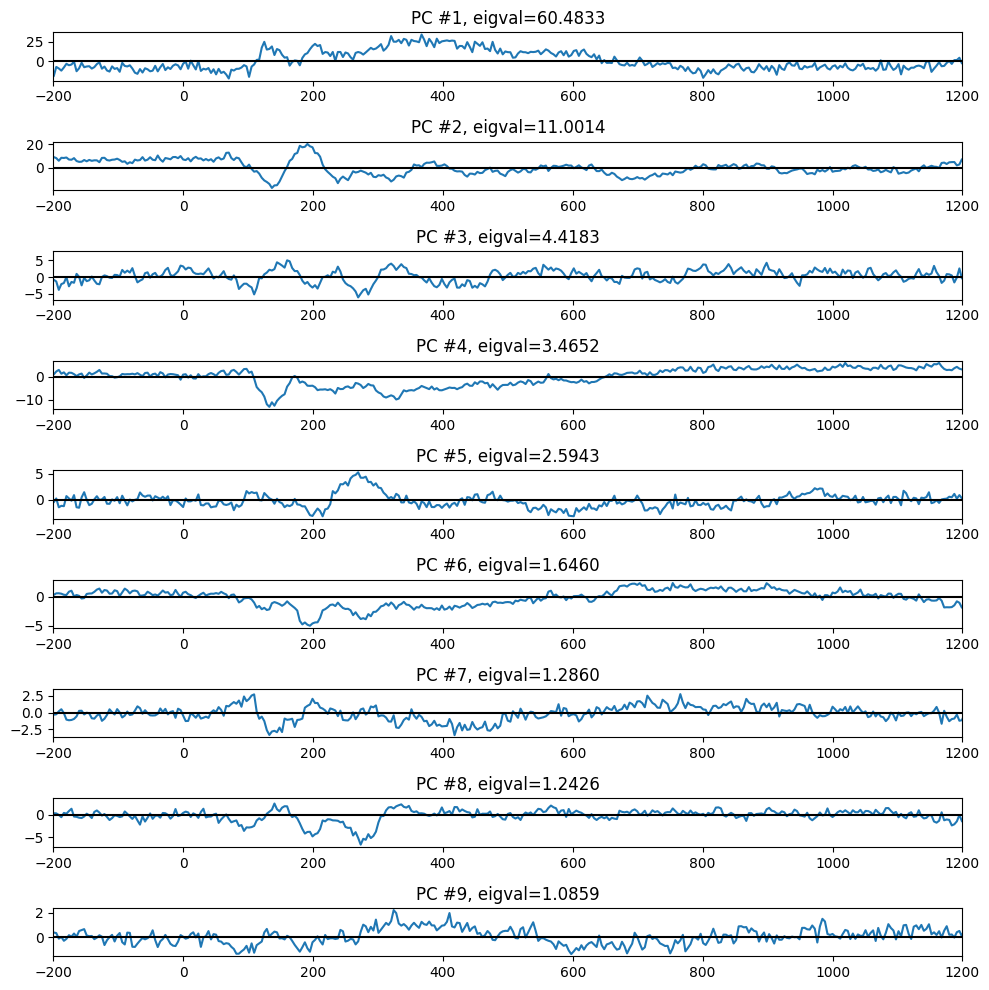

In [ ]:
# Compute covariance of ERP
erp = np.mean(EEG['data'], axis=2)
erp = erp - np.mean(erp, axis=1, keepdims=True)
covar = np.dot(erp, erp.T) / (EEG['pnts'][0][0] - 1)

# PCA via eigenvalue decomposition
eigvals, pc = np.linalg.eig(covar)

pc = pc[:, np.argsort(-eigvals)]
eigvals = np.sort(eigvals)[::-1]
eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
pc_lp = np.delete(pc, exclude_chans, axis=0)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot the first 9 principal components
for i in range(9):
    plt.figure(102, figsize=(10, 10))
    ax = plt.subplot(3, 3, i + 1)
    evoked = EvokedArray(pc_lp[:, i, np.newaxis], info, tmin=EEG['xmin'][0][0])
    evoked.set_montage(montage)
    evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=ax, show=False, times=-1, time_format='', colorbar=False)
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.4f}')

    plt.figure(101, figsize=(10, 10))
    plt.subplot(9, 1, i + 1)
    plt.plot(EEG['times'][0], pc[:, i].T @ erp)
    plt.axhline(0, color='k')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.4f}')

plt.tight_layout()
plt.show()

# Average single-trial covariances
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= EEG['trials'][0][0]

# PCA via eigenvalue decomposition
eigvals, pc = np.linalg.eig(covar)

pc = pc[:, np.argsort(-eigvals)]
eigvals = np.sort(eigvals)[::-1]
eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

pc_lp = np.delete(pc, exclude_chans, axis=0)

# Plot the first 9 principal components
for i in range(9):
    plt.figure(10, figsize=(10, 10))
    ax = plt.subplot(3, 3, i + 1)
    evoked = EvokedArray(pc_lp[:, i, np.newaxis], info, tmin=EEG['xmin'][0][0])
    evoked.set_montage(montage)
    evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=ax, show=False, times=-1, time_format='', colorbar=False)
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.4f}')

    plt.figure(11, figsize=(10, 10))
    ax = plt.subplot(9, 1, i + 1)
    pctimes = np.zeros(EEG['pnts'][0][0])
    for triali in range(EEG['trials'][0][0]):
        eeg = EEG['data'][:, :, triali] - np.mean(EEG['data'][:, :, triali], axis=1, keepdims=True)
        pctimes += pc[:, i].T @ eeg
    plt.plot(EEG['times'][0], pctimes / EEG['trials'][0][0])
    plt.axhline(0, color='k')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.4f}')

plt.tight_layout()
plt.show()

### Tangent

An easily made mistake is to confuse the dimension order of the PC matrix. To be sure you have the correct orientation, plot the first component; it should have a spatially broad ERP-like distribution.

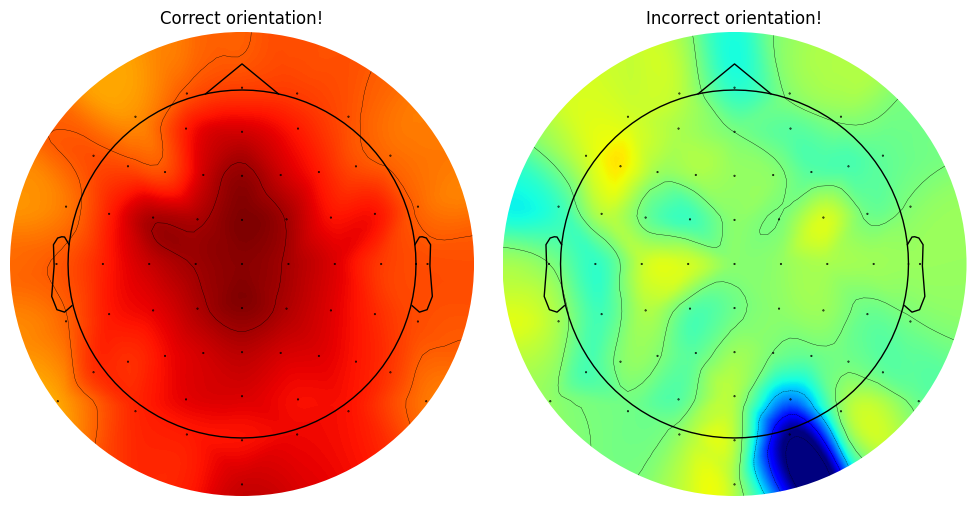

In [ ]:
# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot the first principal component to ensure correct orientation
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
evoked = EvokedArray(pc[:, 0, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[0], show=False, times=-1, time_format='', colorbar=False)
axs[0].set_title('Correct orientation!')

evoked = EvokedArray(pc[0, :, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[1], show=False, times=-1, time_format='', colorbar=False)
axs[1].set_title('Incorrect orientation!')

plt.tight_layout()
plt.show()

### Figure 23.4

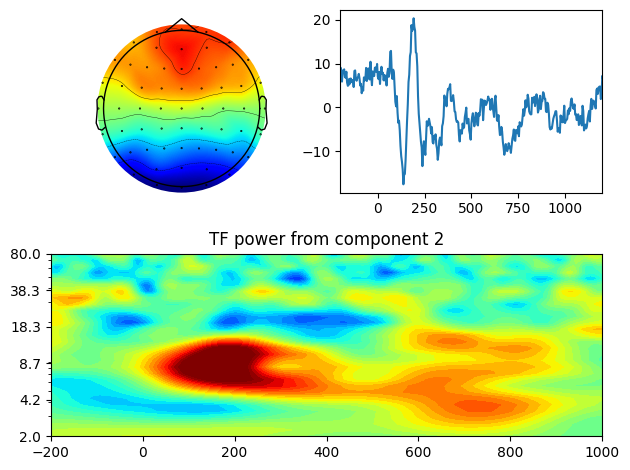

In [ ]:
pcanum = 2 # 1 for panel A; 2 for panel B

# Average single-trial covariances
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= EEG['trials'][0][0]

# PCA via eigenvalue decomposition
eigvals, pc = np.linalg.eig(covar)

pc = pc[:, np.argsort(-eigvals)]
eigvals = np.sort(eigvals)[::-1]
eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

# Project the EEG data onto the chosen principal component for each trial
pcadata = np.zeros((EEG['pnts'][0][0], EEG['trials'][0][0]))
for i in range(EEG['trials'][0][0]):
    # Calculate the PCA scores (projections) for the chosen component
    pcadata[:, i] = np.dot(pc[:, pcanum-1].T, EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True))

min_freq = 2
max_freq = 80
num_frex = 30

# Define wavelet parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
frex = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
s = np.logspace(np.log10(3), np.log10(10), num_frex) / (2 * np.pi * frex)

# Define convolution parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2**np.ceil(np.log2(n_convolution)))
half_of_wavelet_size = (n_wavelet - 1) // 2

# Get FFT of data
eegfft = fft(pcadata.flatten('F'), n_conv_pow2)

# Initialize
eegpower = np.zeros((num_frex, EEG['pnts'][0][0]))  # frequencies X time X trials

baseidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in [-500, -200]]

# Loop through frequencies and compute synchronization
for fi in range(num_frex):
    wavelet = fft(np.exp(2 * 1j * np.pi * frex[fi] * time) * np.exp(-time ** 2 / (2 * (s[fi] ** 2))), n_conv_pow2)
    
    eegconv = ifft(wavelet * eegfft)
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    
    temppower = np.mean(np.abs(np.reshape(eegconv, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')) ** 2, axis=1)
    eegpower[fi, :] = 10 * np.log10(temppower / np.mean(temppower[baseidx[0]:baseidx[1]+1]))

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
pc_lp = np.delete(pc, exclude_chans, axis=0)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plotting the results
ax = plt.subplot(221)
evoked = EvokedArray(pc_lp[:, pcanum-1, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=ax, show=False, times=-1, time_format='', colorbar=False)
plt.subplot(222)
plt.plot(EEG['times'][0], np.mean(pcadata, axis=1))
plt.xlim([-200, 1200])

plt.subplot(212)
plt.contourf(EEG['times'][0], frex, eegpower, 40, cmap='jet')
plt.clim([-3, 3])
plt.xlim([-200, 1000])
plt.yscale('log')
plt.yticks(np.logspace(np.log10(min_freq), np.log10(max_freq), 6))
plt.gca().set_yticklabels([f'{f:.1f}' for f in np.logspace(np.log10(min_freq), np.log10(max_freq), 6)])
plt.title(f'TF power from component {pcanum}')

plt.tight_layout()
plt.show()

### Figure 23.5

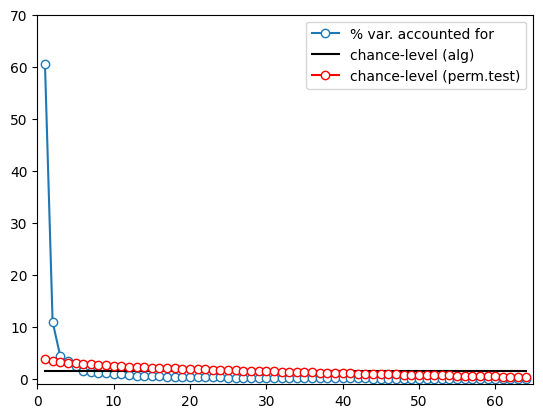

In [ ]:
# Recompute PCA
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= EEG['trials'][0][0]
eigvals, pc = np.linalg.eig(covar)
eigvals = 100 * np.sort(eigvals)[::-1] / np.sum(eigvals)  # Convert to percent change

# Plot eigenvalues as percent variance accounted for
plt.plot(np.arange(1, len(eigvals)+1), eigvals, '-o', markerfacecolor='w')
plt.ylim([-1, 70])
plt.xlim([0, 65])

# Amount of variance expected by chance, computed analytically
plt.plot([1, EEG['nbchan'][0][0]], [100 / EEG['nbchan'][0][0]] * 2, 'k')

# Amount of variance expected by chance, computed based on random data
nperms = 1000
permeigvals = np.zeros((nperms, EEG['nbchan'][0][0]))
for permi in range(nperms):
    # Randomize ERP time points within each channel
    randdat = np.copy(erp)
    for ch in range(erp.shape[0]):
        np.random.shuffle(randdat[ch, :])
    # Compute covariance matrix of the randomized data
    covar = np.dot(randdat, randdat.T) / (EEG['pnts'][0][0] - 1)
    # Perform eigenvalue decomposition
    eigvals, pc = np.linalg.eig(covar)
    eigvals = np.sort(eigvals)[::-1]  # Sort eigenvalues in descending order
    permeigvals[permi, :] = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

plt.plot(np.arange(1, len(np.mean(permeigvals, axis=0))+1), np.mean(permeigvals, axis=0), 'r-o', markerfacecolor='w')
plt.legend(['% var. accounted for', 'chance-level (alg)', 'chance-level (perm.test)'])
plt.show()

### Figure 23.6

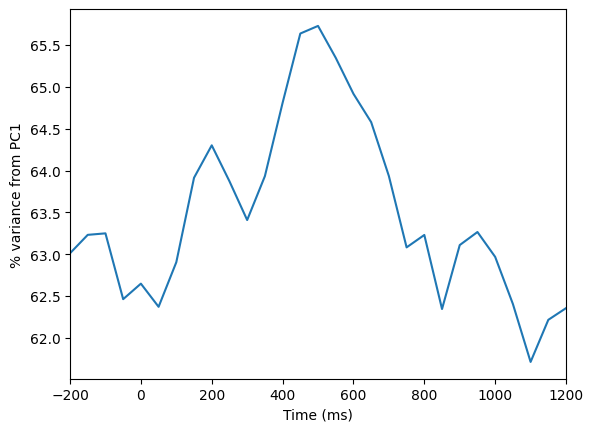

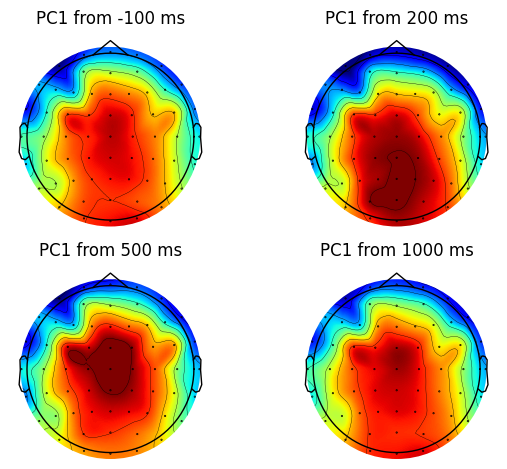

In [ ]:
# Define parameters
whichcomp = 1 # 1 for panel A; 2 for panel B

centertimes = np.arange(-200, 1201, 50)
timewindow = 200  # ms on either side of center times
maptimes = np.array([-100, 200, 500, 1000] if whichcomp == 1 else [0, 300, 750, 1000])
clim = (80000, 150000) if whichcomp == 1 else (-200000, 200000)

# Initialize variables
pcvariance = np.zeros(len(centertimes))
firstpcas = np.zeros((len(centertimes), EEG['nbchan'][0][0]))

timesidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in centertimes]
timewinidx = round(timewindow / (1000 / EEG['srate'][0][0]))
mapsidx = [np.argmin(np.abs(centertimes - t)) for t in maptimes]

# Perform temporally localized PCA
for ti, center_time in enumerate(centertimes):
    # Temporally localized covariance
    covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
    for i in range(EEG['trials'][0][0]):
        eeg = EEG['data'][:, timesidx[ti] - timewinidx:timesidx[ti] + timewinidx + 1, i]
        eeg = eeg - np.mean(eeg, axis=1, keepdims=True)
        covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
    covar /= EEG['trials'][0][0]
    
    # PCA via eigenvalue decomposition
    eigvals, pc = np.linalg.eig(covar)
    pc = pc[:, np.argsort(-eigvals)]
    eigvals = np.sort(eigvals)[::-1]
    eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change
    
    pcvariance[ti] = eigvals[whichcomp - 1]
    firstpcas[ti, :] = pc[:, whichcomp - 1]

# Adjust the sign of the principal components for consistent visualization.
# Just do it for the first component since its visualization is only in the positive range.
if whichcomp == 1:
    for i in range(firstpcas.shape[0]):
        if np.sum(firstpcas[i, :]) < 0:
            firstpcas[i, :] = -firstpcas[i, :]

# Plot variance over time
plt.plot(centertimes, pcvariance)
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel(f'% variance from PC{whichcomp}')
plt.show()

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
firstpcas = np.delete(firstpcas, exclude_chans, axis=1)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot topomaps at specified times
for i, maptime in enumerate(maptimes):
    ax = plt.subplot(int(np.ceil(len(maptimes) / np.ceil(np.sqrt(len(maptimes))))), int(np.ceil(np.sqrt(len(maptimes)))), i + 1)
    evoked = EvokedArray(firstpcas[mapsidx[i], :, np.newaxis], info, tmin=EEG['xmin'][0][0])
    evoked.set_montage(montage)
    evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=clim, axes=ax, show=False, times=-1, time_format='', colorbar=False)
    plt.title(f'PC{whichcomp} from {maptime} ms')

plt.tight_layout()
plt.show()

### Figure 23.7

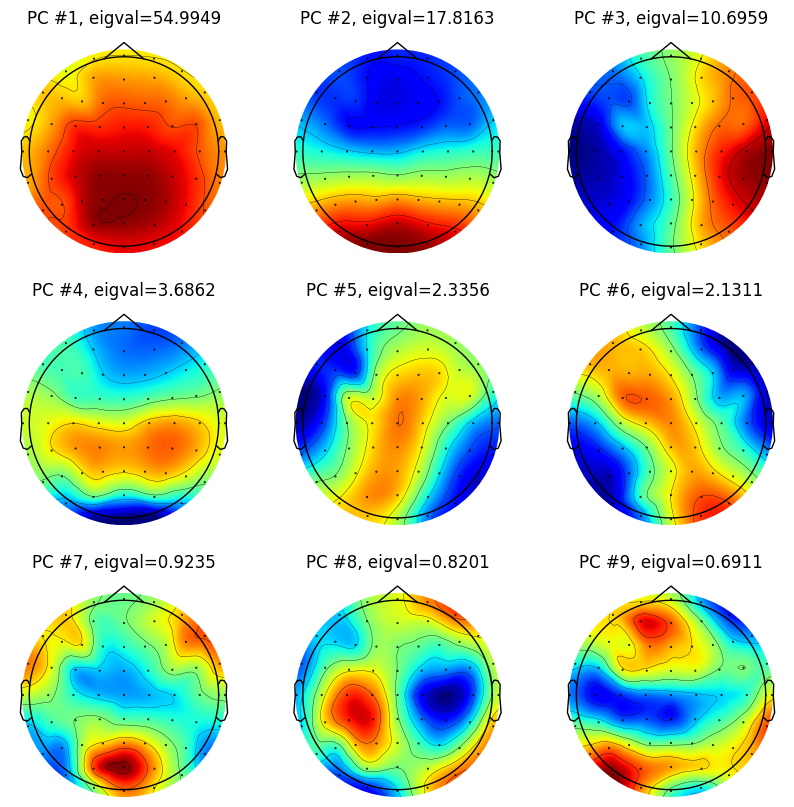

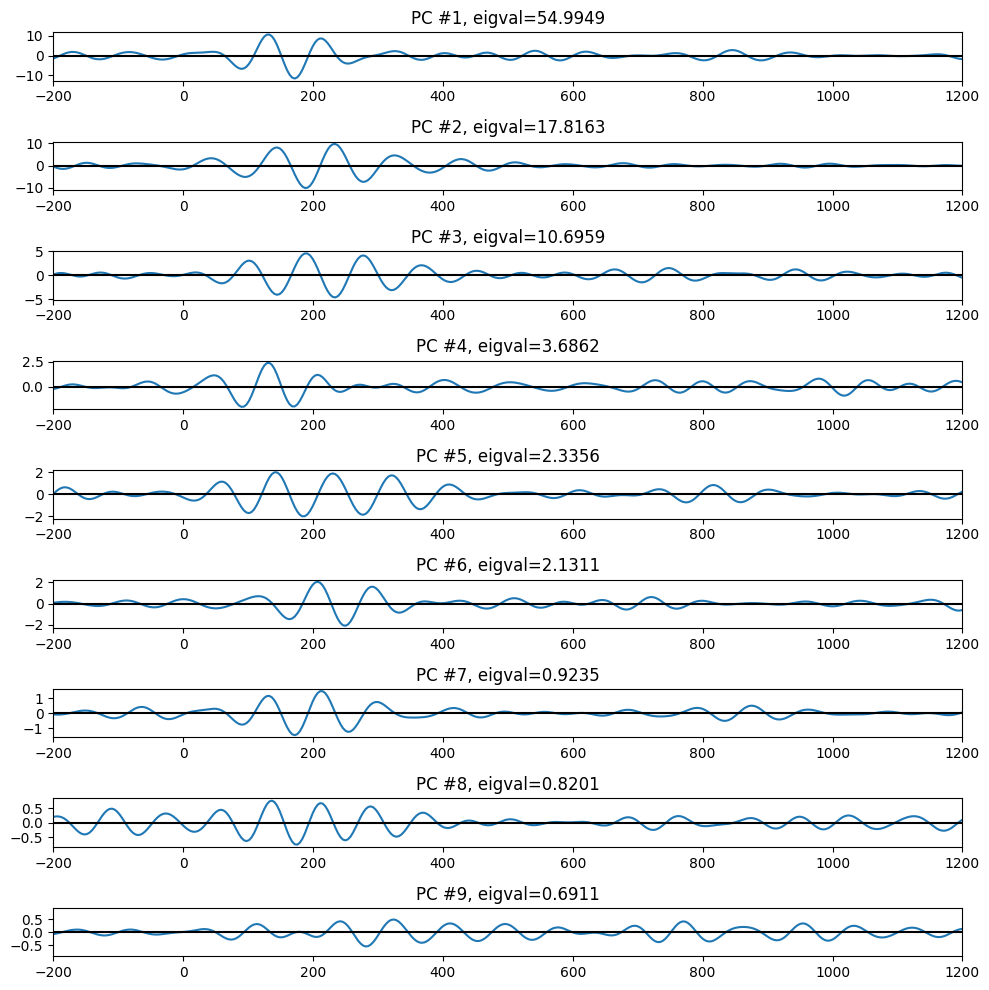

In [ ]:
# Filter parameters
center_freq = 12  # in Hz
filter_frequency_spread = 3  # Hz +/- the center frequency
transition_width = 0.2

# Construct filter kernel
nyquist = EEG['srate'][0][0] / 2
filter_order = round(3 * (EEG['srate'][0][0] / (center_freq - filter_frequency_spread)))

ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread), (center_freq - filter_frequency_spread), (center_freq + filter_frequency_spread), (1 + transition_width) * (center_freq + filter_frequency_spread), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(filter_order, ffrequencies, idealresponse)

# Filter the data
filter_result = filtfilt(filterweights, 1, np.reshape(EEG['data'], (EEG['nbchan'][0][0], EEG['pnts'][0][0] * EEG['trials'][0][0]), 'F'))
filter_result = np.reshape(filter_result, (EEG['nbchan'][0][0], EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Perform PCA on filtered data
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = filter_result[:, :, i] - np.mean(filter_result[:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= EEG['trials'][0][0]

eigvals, pc = np.linalg.eig(covar)

pc = pc[:, np.argsort(-eigvals)]
eigvals = np.sort(eigvals)[::-1]
eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
pc_lp = np.delete(pc, exclude_chans, axis=0)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot the first 9 principal components
for i in range(9):
    plt.figure(10, figsize=(10, 10))
    ax = plt.subplot(3, 3, i + 1)
    evoked = EvokedArray(pc_lp[:, i, np.newaxis], info, tmin=EEG['xmin'][0][0])
    evoked.set_montage(montage)
    evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=ax, show=False, times=-1, time_format='', colorbar=False)
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.4f}')

    plt.figure(11, figsize=(10, 10))
    plt.subplot(9, 1, i + 1)
    plt.plot(EEG['times'][0], pc[:, i].T @ np.mean(filter_result, axis=2))
    plt.axhline(0, color='k')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.4f}')

plt.tight_layout()
plt.show()

### Figure 23.8

Note about this code: The legend of this figure (page 304) states that the PCA computed on all trials and then the weights were separately applied to the first and last 30 trials. However, in the code below (and thus, in the book figure), the PCA is actually computed separately on the first and last 30 trials.

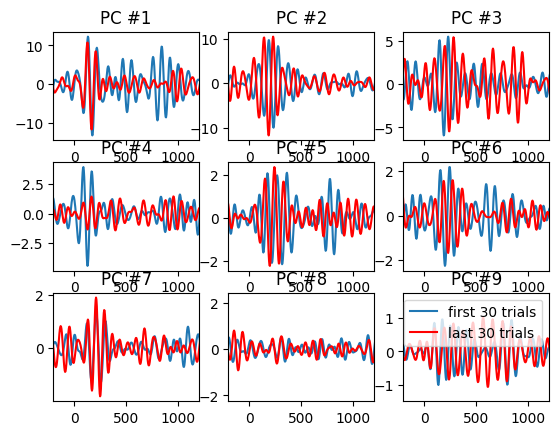

In [ ]:
# PCA on first 30 trials
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(30):
    eeg = filter_result[:, :, i] - np.mean(filter_result[:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= 30

eigvals, pc_first = np.linalg.eig(covar)
pc_first = pc_first[:, np.argsort(-eigvals)]

# PCA on last 30 trials
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0] - 30, EEG['trials'][0][0]):
    eeg = filter_result[:, :, i] - np.mean(filter_result[:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= 30
eigvals, pc_last = np.linalg.eig(covar)
pc_last = pc_last[:, np.argsort(-eigvals)]

# Plot the first 9 principal components for first and last 30 trials
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.plot(EEG['times'][0], pc_first[:, i].T @ np.mean(filter_result[:, :, :30], axis=2))
    plt.plot(EEG['times'][0], pc_last[:, i].T @ np.mean(filter_result[:, :, -30:], axis=2), 'r')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}')
plt.legend(['first 30 trials', 'last 30 trials'])
plt.show()